In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt



c:\Users\maril\anaconda3\envs\pythonProject\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plot_xyz_timeseries(time, data, ylabel, title):
    # Plot the time series
    fig, ax = plt.subplots(3,1, figsize=(12, 8))
    ax[0].plot(time, data['x'])
    ax[1].plot(time, data['y'])
    ax[2].plot(time, data['z'])
    ax[0].set(xlabel='x')
    ax[1].set(xlabel='y')
    ax[2].set(xlabel='z')
    ax[2].set_xlabel('time')
    ax[0].set_ylabel(ylabel)
    plt.show()
    plt.figure()
    (data.loc[ : , data.columns != 'time']).hist()
    plt.show()


def zero_mean_df(df, exlude_time = False):
    if exlude_time:
        df_xyz = df.loc[:, df.columns != 'time']
        df_xyz = df_xyz- df_xyz.mean()
        df.loc[:, df.columns != 'time'] = df_xyz
    else:
        df = df - df.mean()
    return df

def saveStatistics(filename, df):
    agg = df.agg( {
        "x": ["min", "max", "median", "skew", "kurtosis", "mean", "std"],
        "y": ["min", "max", "median", "skew", "kurtosis", "mean", "std"],
        "z": ["min", "max", "median", "skew", "kurtosis", "mean", "std"],
        
    }, skipna = True, numeric_only = True
)
    agg.to_csv(filename, sep=',')
    print(agg)

In [3]:
#AIC and BIC
def findPQ(data, maxP, maxQ):
    order_aic_bic = []

    # Loop over p values from 0-2
    for p in range(maxP):
        # Loop over q values from 0-2
        for q in range(maxQ):
            # Create and fit ARMA(p, q) model
            model = SARIMAX(data, order=(p, 0, q))
            results = model.fit()
            
            # Append order and results tuple
            order_aic_bic.append((p, q, results.aic, results.bic))
    order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'AIC', 'BIC'])

    # Print order_df in order of increasing AIC
    print(order_df.sort_values('AIC'))

    # Print order_df in order of increasing BIC
    print(order_df.sort_values('BIC'))

In [4]:
#Plot the best fitted ARMA model
def evaluateARMA(data, p, q, model):
    # Print the model summary
    print(f'ARMA({p},{q}) Model Results:\n{model.summary()}\n')

    # Plot the model residuals
    residuals11 = model.resid[1:]
    fig, ax = plt.subplots(1,2)
    residuals11.plot(title=f'ARMA({p},{q}) Residuals', ax=ax[0], figsize=(12, 8))
    residuals11.plot(title='Density', kind='kde', ax=ax[1], figsize=(12, 8))
    plt.show()

    # Plot fitted model with real model
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(model.simulate(data.size))
    ax.plot(data)
    ax.set_xlabel('Time')
    ax.set_ylabel('Magnetic field')
    ax.set_title(f'ARMA({p},{q}) fit vs real')
    plt.show()
            

In [5]:
def testModel(data_train, data_test, model, axis):
    # test forecast on test set
    forecast    = model.forecast(len(data_train), alpha=0.05)
    predict     = model.predict(start = len(data_train), end=(len(data_train) + len(data_train)-1))
    # Make as pandas series
    #fc_series = pd.Series(forecast10, index=data_test.index)
    #lower_series = pd.Series(conf[:, 0], index=data_test.index)
    #upper_series = pd.Series(conf[:, 1], index=data_test.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(data_train['time'], data_train[axis], label='training')
    plt.plot(data_test['time'], data_test[axis], label='actual')
    plt.plot(data_test['time'], predict, label='prediction')
    plt.plot(data_test['time'], forecast, label='forecast')
    #plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()


C:\Users\maril\AppData\Local\Temp\ipykernel_33596\1428667040.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv("Plotting\\TestingData\\IMUtest.csv", sep = ', ', header=0)


                  x          y          z
min        9.560000 -13.560000 -51.500000
max       14.690000 -10.250000 -46.250000
median    11.880000 -12.060000 -49.190000
skew      -0.089961   0.070246   0.011081
kurtosis  -0.136997   0.283546   0.019536
mean      11.893730 -11.990014 -49.109421
std        0.637218   0.384884   0.613116


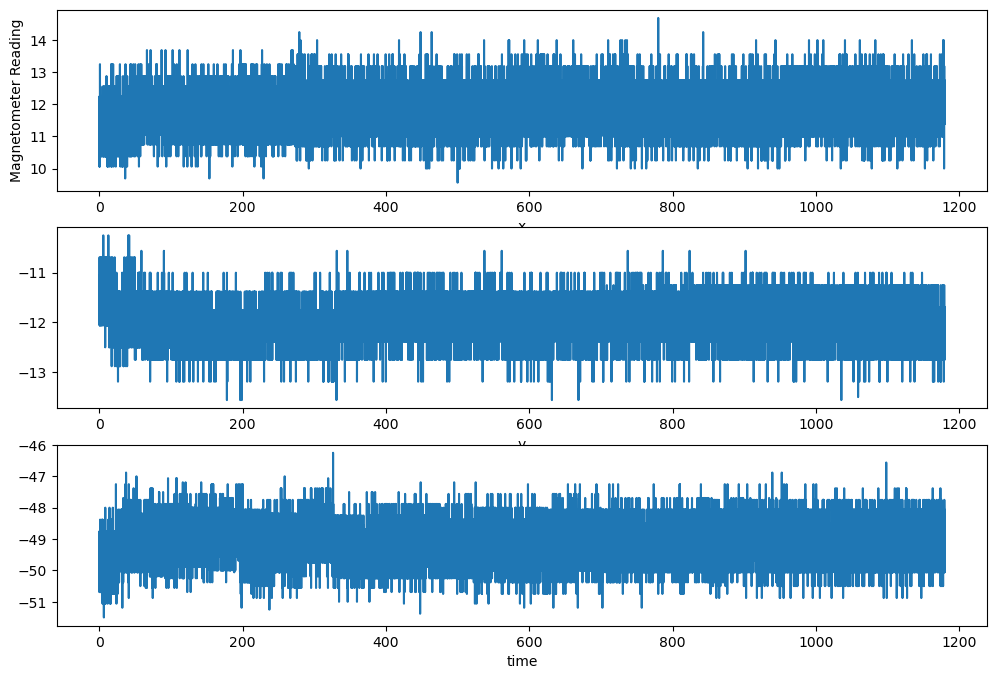

<Figure size 640x480 with 0 Axes>

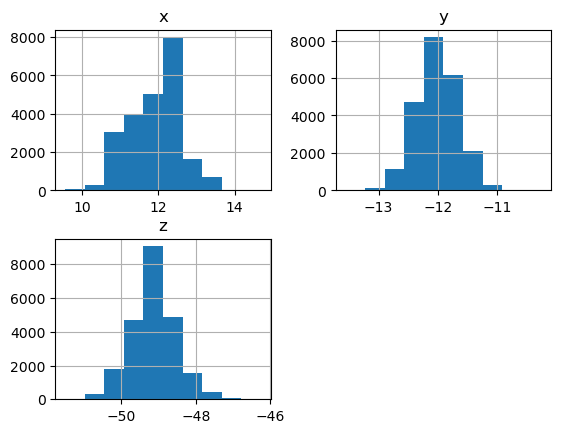

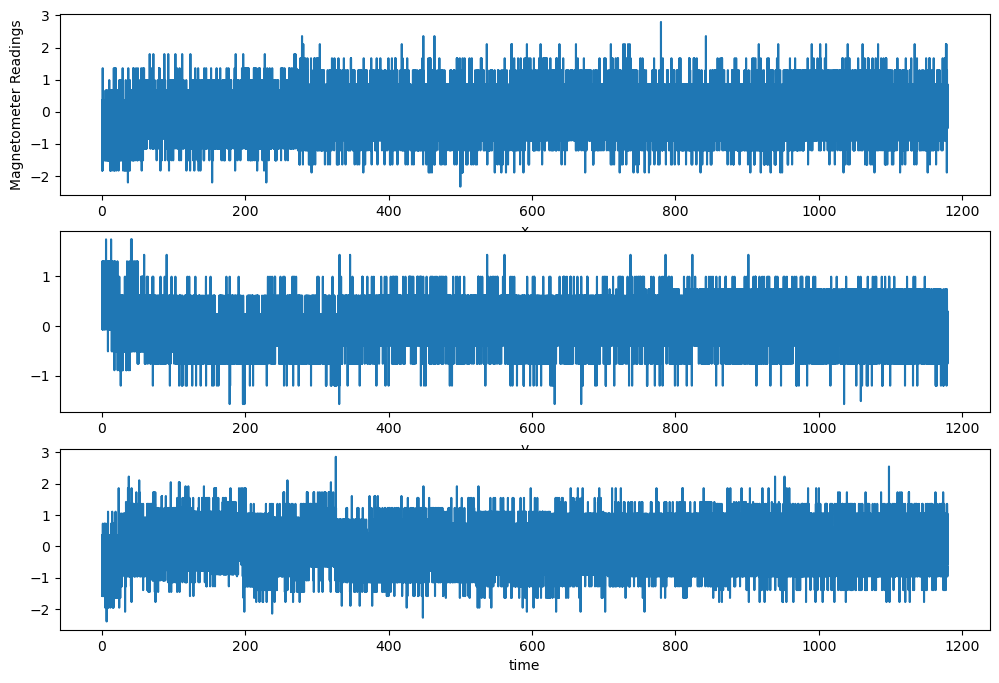

<Figure size 640x480 with 0 Axes>

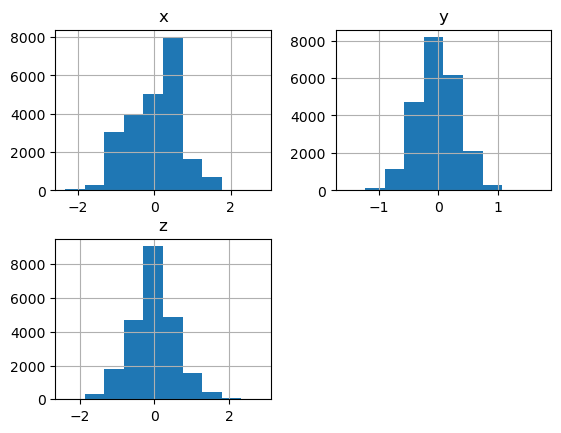

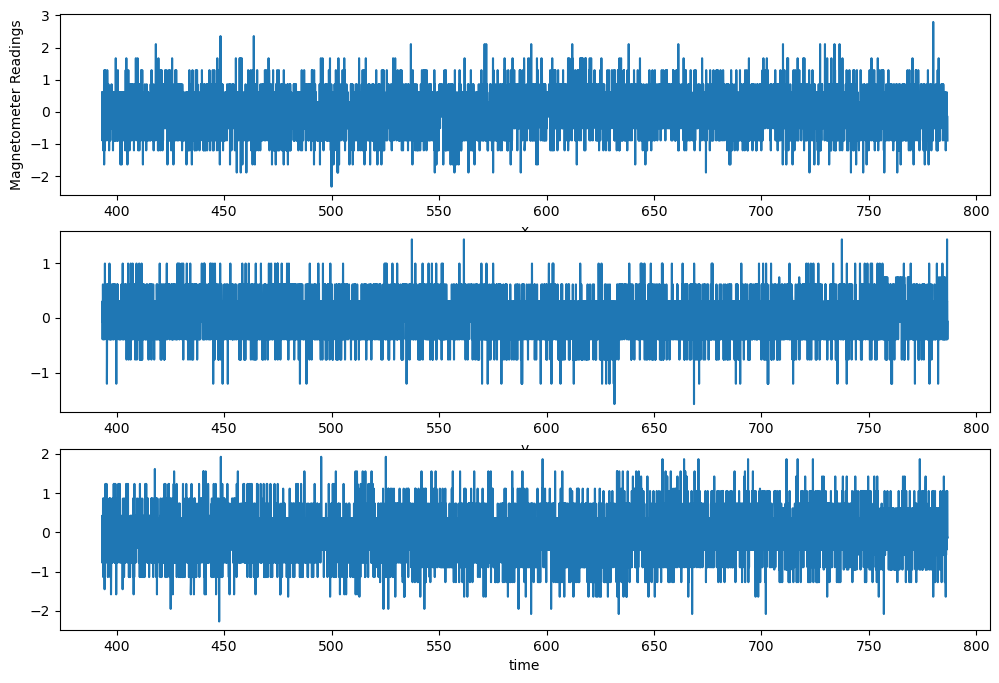

<Figure size 640x480 with 0 Axes>

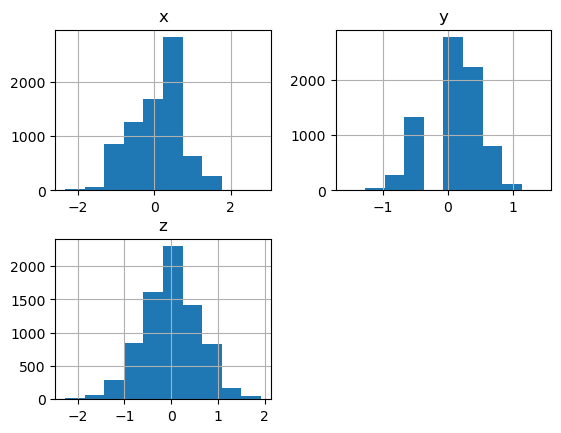

In [14]:
# Read in the CSV file containing magnetometer data
#data = pd.read_csv('test.txt', header=None, names=['x', 'y', 'z', 'time'])

data = pd.read_csv("Plotting\\TestingData\\IMUtest.csv", sep = ', ', header=0)
saveStatistics("IMUNoiseCharStatistics.csv", data)
#timestamps = pd.read_csv('newtest//oneSetTimestamps.csv')

plot_xyz_timeseries(data['time'], data, 'Magnetometer Reading', 'Available magentometer time series data test.txt')

data = zero_mean_df(data, exlude_time = True)

plot_xyz_timeseries(data['time'], data, 'Magnetometer Readings', 'zero meaned')

#Devide timeseries into traning, test and validation set 
n = len(data.index)
n_train = n_test = n_val = n//3
data_train = data.iloc[0 : n_train]
data_test = data.iloc[n_train : n_train + n_test]
data_val = data.iloc[n_train + n_test:]



c:\Users\maril\anaconda3\envs\pythonProject\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


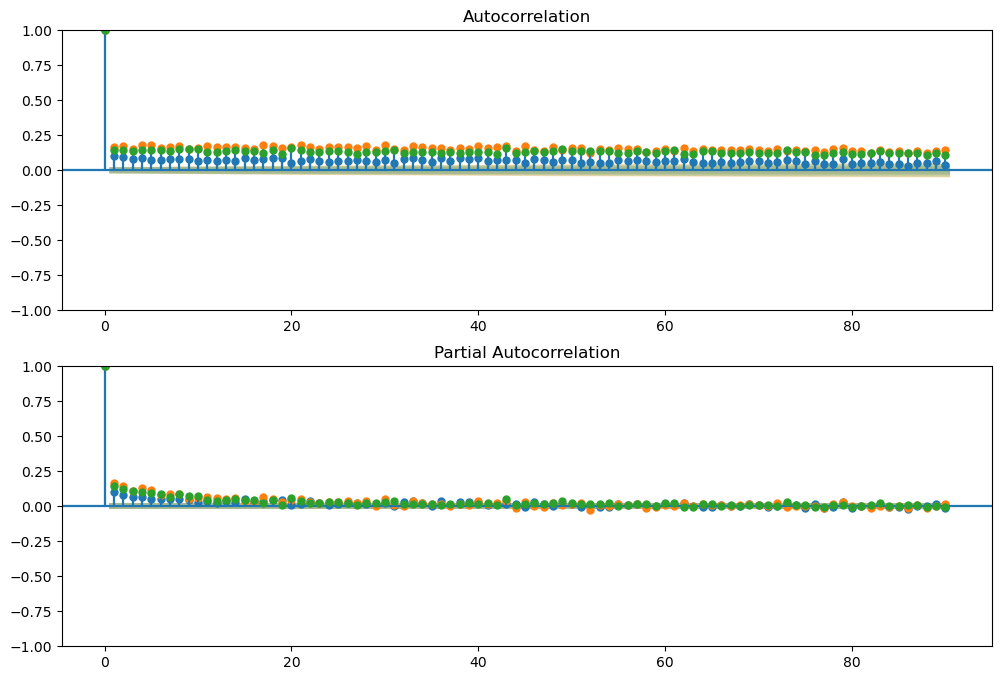

In [7]:
#plot autocorrelation
#train data on ARMA (zero meaning it!)

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_train['x'].values.squeeze(), lags=90, ax=ax1, alpha = 0.05)
fig = sm.graphics.tsa.plot_acf(data_train['y'].values.squeeze(), lags=90, ax=ax1, alpha = 0.05)
fig = sm.graphics.tsa.plot_acf(data_train['z'].values.squeeze(), lags=90, ax=ax1, alpha = 0.05)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_train['x'], lags=90, ax=ax2, alpha = 0.05)
fig = sm.graphics.tsa.plot_pacf(data_train['y'], lags=90, ax=ax2, alpha = 0.05)
fig = sm.graphics.tsa.plot_pacf(data_train['z'], lags=90, ax=ax2, alpha = 0.05)
plt.show()

In [17]:
print("AIC/BIC for x")
findPQ(data_train['x'], 4, 4)
print("AIC/BIC for y")
findPQ(data_train['y'], 4, 4)
print("AIC/BIC for z")
findPQ(data_train['z'], 4, 4)

AIC/BIC for x


c:\Users\maril\anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\maril\anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\maril\anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\maril\anaconda3\envs\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum

    p  q           AIC           BIC
9   2  1  14373.513475  14401.250241
6   1  2  14373.644819  14401.381586
13  3  1  14373.820151  14408.491109
7   1  3  14373.923588  14408.594545
5   1  1  14375.844823  14396.647398
14  3  2  14377.468038  14419.073187
11  2  3  14377.568916  14419.174065
10  2  2  14379.334086  14414.005044
15  3  3  14431.228055  14479.767396
12  3  0  14756.350910  14784.087676
3   0  3  14793.068637  14820.805403
8   2  0  14798.401240  14819.203815
2   0  2  14826.186520  14846.989094
4   1  0  14863.013503  14876.881886
1   0  1  14878.563853  14892.432236
0   0  0  14961.098239  14968.032430
    p  q           AIC           BIC
5   1  1  14375.844823  14396.647398
9   2  1  14373.513475  14401.250241
6   1  2  14373.644819  14401.381586
13  3  1  14373.820151  14408.491109
7   1  3  14373.923588  14408.594545
10  2  2  14379.334086  14414.005044
14  3  2  14377.468038  14419.073187
11  2  3  14377.568916  14419.174065
15  3  3  14431.228055  14479.767396
1

c:\Users\maril\anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\maril\anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\maril\anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\maril\anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as 

    p  q          AIC          BIC
5   1  1  6254.357012  6275.159587
6   1  2  6256.168103  6283.904869
9   2  1  6256.168477  6283.905243
10  2  2  6257.531637  6292.202595
13  3  1  6258.167247  6292.838204
7   1  3  6258.543501  6293.214459
11  2  3  6259.549904  6301.155053
14  3  2  6259.705615  6301.310764
15  3  3  6261.013350  6309.552691
12  3  0  7047.812180  7075.548946
8   2  0  7141.563536  7162.366111
3   0  3  7180.446224  7208.182990
2   0  2  7235.890151  7256.692726
4   1  0  7314.453504  7328.321887
1   0  1  7367.105677  7380.974060
0   0  0  7542.088624  7549.022815
    p  q          AIC          BIC
5   1  1  6254.357012  6275.159587
6   1  2  6256.168103  6283.904869
9   2  1  6256.168477  6283.905243
10  2  2  6257.531637  6292.202595
13  3  1  6258.167247  6292.838204
7   1  3  6258.543501  6293.214459
11  2  3  6259.549904  6301.155053
14  3  2  6259.705615  6301.310764
15  3  3  6261.013350  6309.552691
12  3  0  7047.812180  7075.548946
8   2  0  7141.56353

c:\Users\maril\anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\maril\anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\maril\anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\maril\anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as 

    p  q           AIC           BIC
5   1  1  13711.392739  13732.195314
6   1  2  13713.386346  13741.123112
9   2  1  13713.386377  13741.123144
10  2  2  13713.782620  13748.453578
14  3  2  13715.330062  13756.935211
13  3  1  13715.368454  13750.039411
7   1  3  13715.368511  13750.039469
15  3  3  13716.750082  13765.289423
11  2  3  13717.101323  13758.706473
12  3  0  14373.474730  14401.211496
8   2  0  14457.240232  14478.042806
3   0  3  14461.540803  14489.277569
2   0  2  14518.290817  14539.093391
4   1  0  14578.267687  14592.136070
1   0  1  14609.287706  14623.156089
0   0  0  14732.931765  14739.865957
    p  q           AIC           BIC
5   1  1  13711.392739  13732.195314
6   1  2  13713.386346  13741.123112
9   2  1  13713.386377  13741.123144
10  2  2  13713.782620  13748.453578
13  3  1  13715.368454  13750.039411
7   1  3  13715.368511  13750.039469
14  3  2  13715.330062  13756.935211
11  2  3  13717.101323  13758.706473
15  3  3  13716.750082  13765.289423
1

ARMA(1,1) Model Results:
                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                 7587
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7183.817
Date:                Tue, 18 Apr 2023   AIC                          14375.634
Time:                        12:28:04   BIC                          14403.371
Sample:                             0   HQIC                         14385.153
                               - 7587                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0945      0.057     -1.667      0.095      -0.206       0.017
ar.L1          0.9972      0.001    981.118      0.000       0.995       0.999
ma.L1         -0.9765      

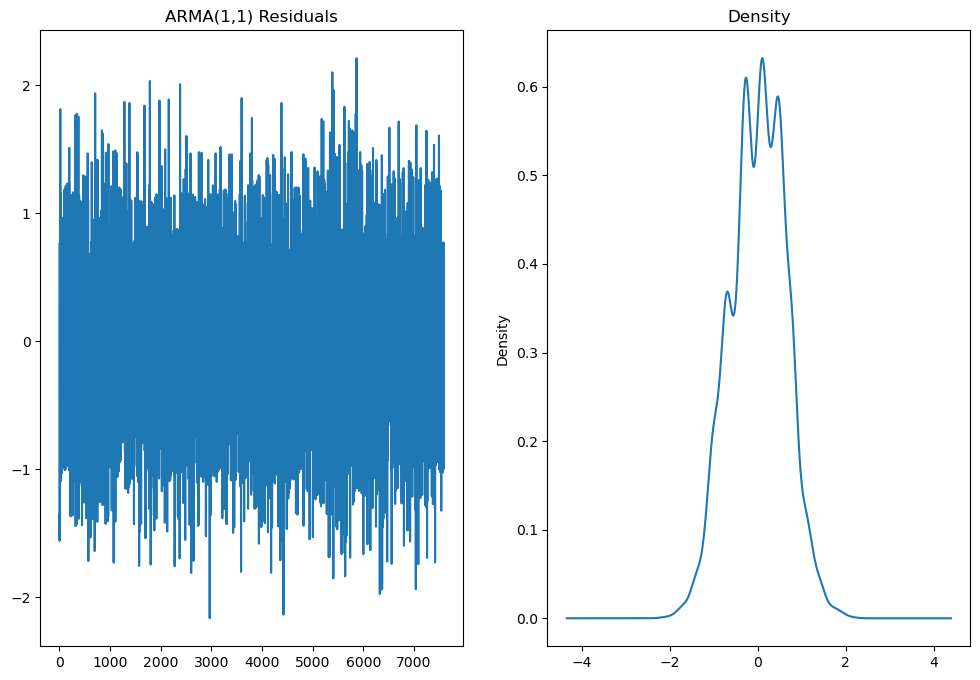

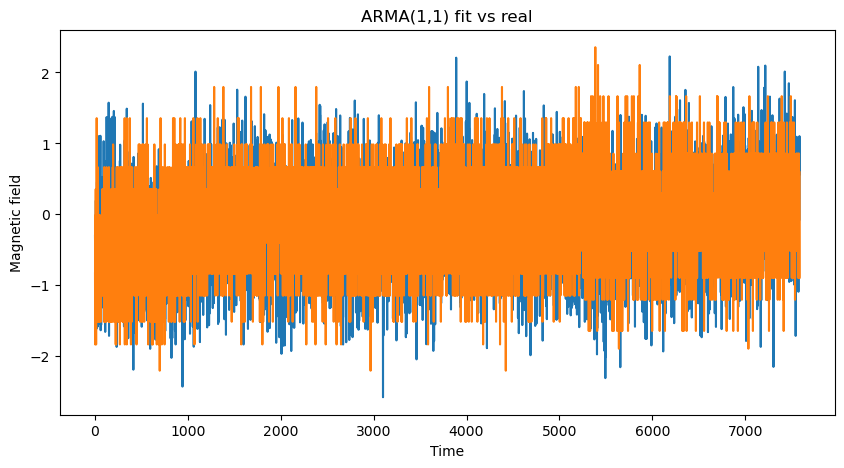

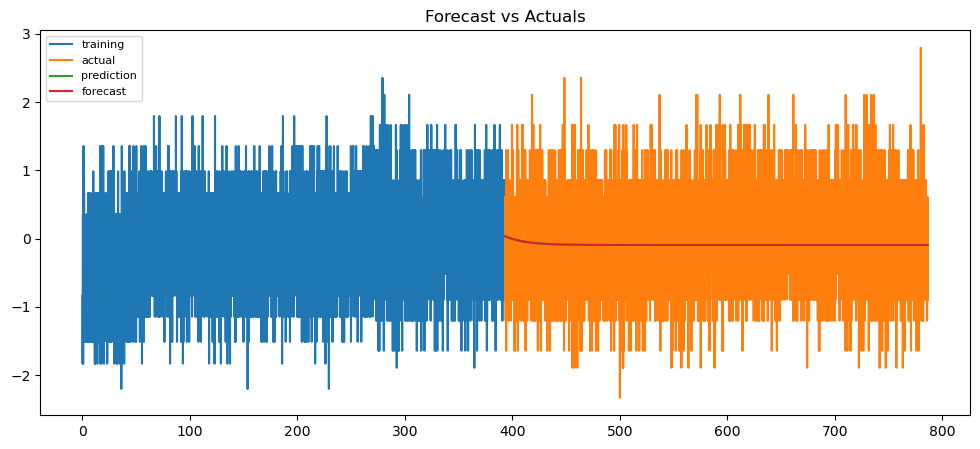

ARMA(1,1) Model Results:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7587
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3124.080
Date:                Tue, 18 Apr 2023   AIC                           6256.161
Time:                        12:28:09   BIC                           6283.897
Sample:                             0   HQIC                          6265.680
                               - 7587                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0440      0.095      0.465      0.642      -0.141       0.229
ar.L1          0.9990      0.000   2109.629      0.000       0.998       1.000
ma.L1         -0.9751      

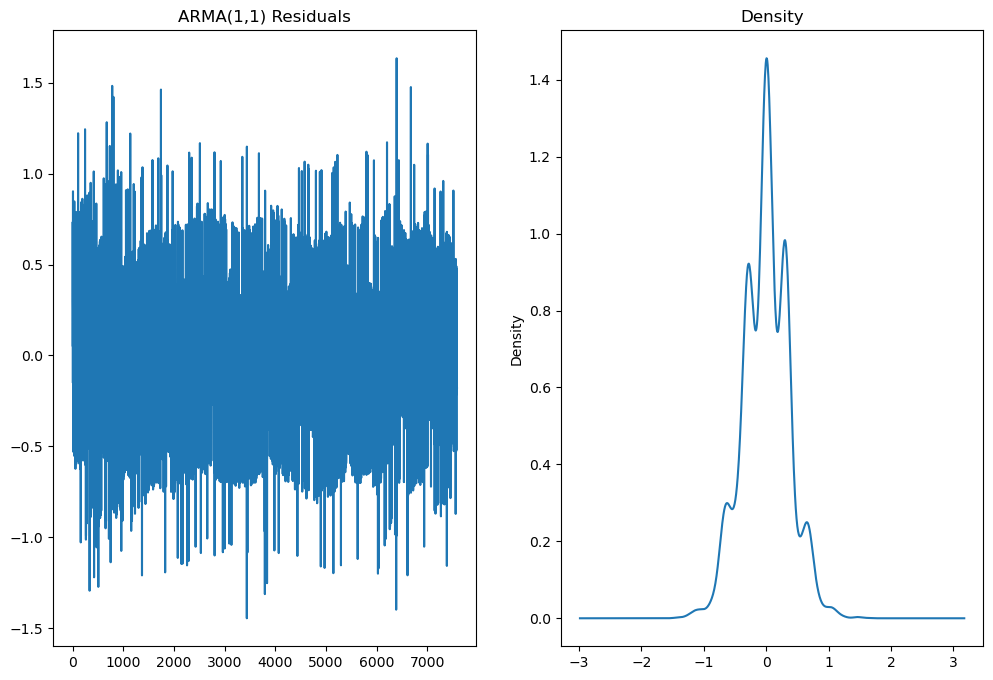

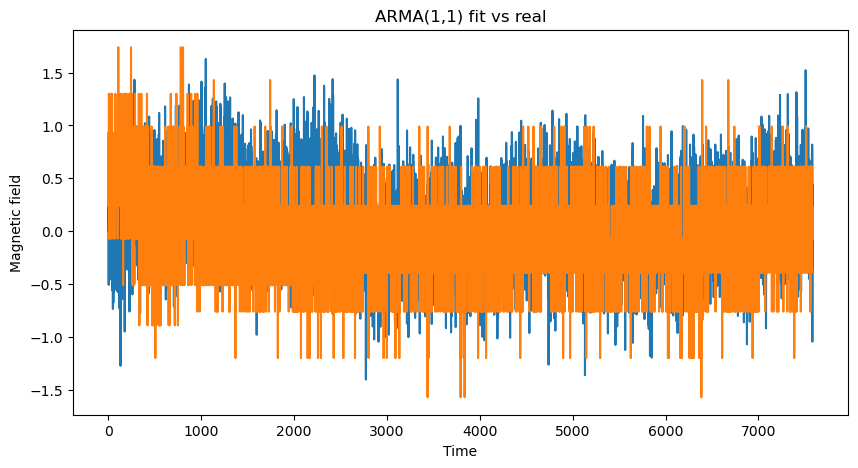

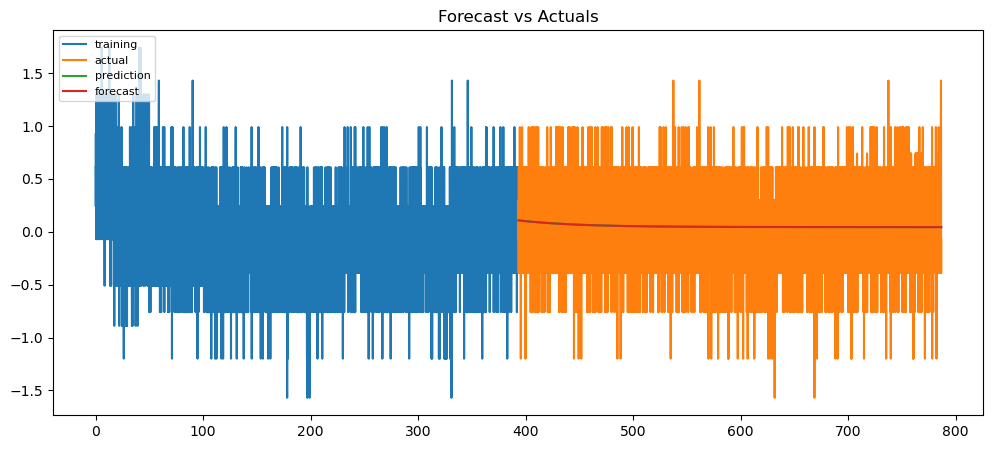

ARMA(1,1) Model Results:
                               SARIMAX Results                                
Dep. Variable:                      z   No. Observations:                 7587
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -6852.529
Date:                Tue, 18 Apr 2023   AIC                          13713.059
Time:                        12:28:13   BIC                          13740.795
Sample:                             0   HQIC                         13722.578
                               - 7587                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0739      0.121     -0.610      0.542      -0.312       0.164
ar.L1          0.9990      0.000   2141.963      0.000       0.998       1.000
ma.L1         -0.9793      

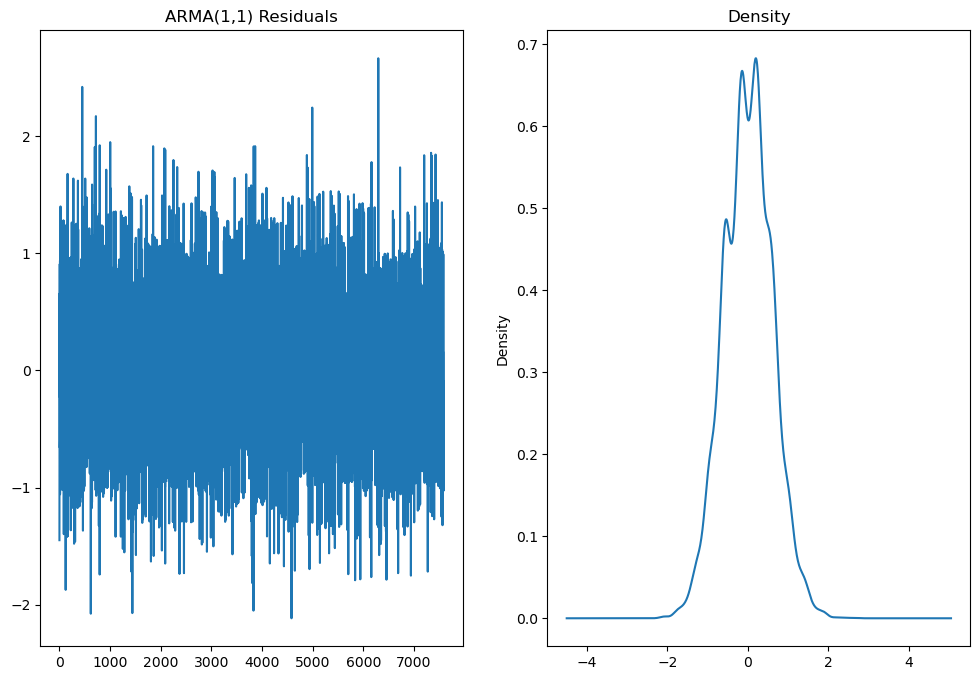

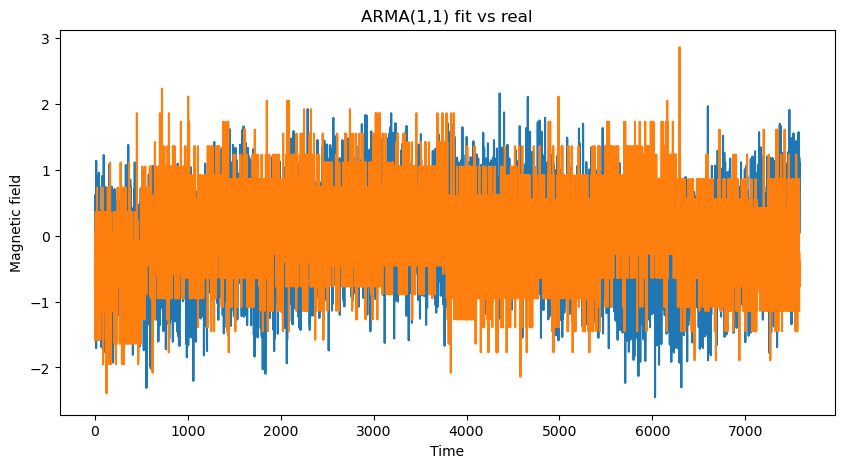

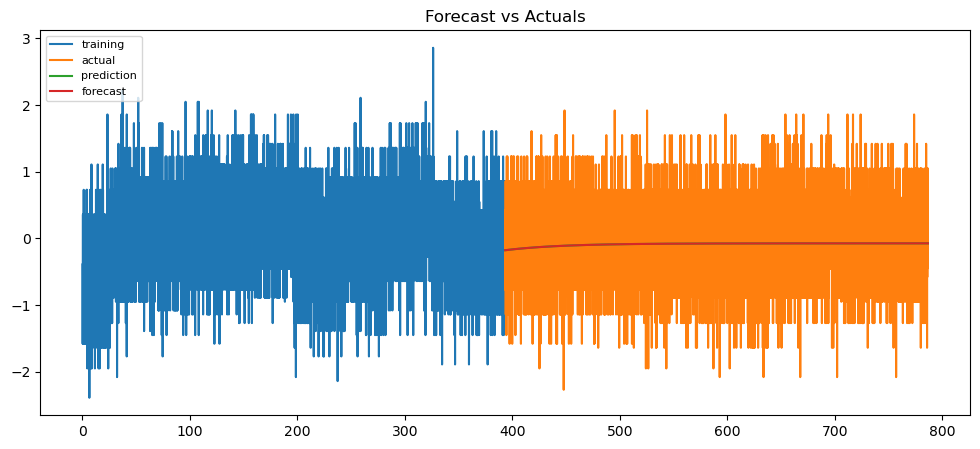

In [19]:
#Plot the best fitted ARMA model
p = 1
q = 1


for element in ['x', 'y', 'z']:
    arma_model = ARIMA(data_train[element], order=(p,0,q))
    model = arma_model.fit()
    evaluateARMA(data_train[element], p, q, model)
    testModel(data_train, data_test, model, element)